## Imports

In [44]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
from pathlib import Path
import pandas as pd
import numpy as np

import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import GAT
from torch_geometric.nn.conv import GATv2Conv
from torch_geometric.data import Data
import pandas as pd
import networkx as nx

from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score

import itertools
from tqdm import tqdm
import re

In [45]:
file_name = 'vk_combined'
group_size = 5_00
user_id = 113074851

def line_to_users(line):
    return split_line(line)[1:]

def split_line(line):
    return re.split(';|,', line.strip())[:]

# Извлекаем все пары пользователей в одном сообществе (ненаправленные)
def combinations(seq):
    yield from itertools.combinations(seq, 2)

In [46]:
# from collections import Counter

# def select_cool(extract_dir):
#     edges = []
#     with open(extract_dir, 'r') as f:
#         for line in tqdm(f):
#             the_line = line_to_users(line)
#             edges+=the_line
#             # if i > 3: break
#     print('Returning')
#     print(Counter(edges).most_common(10))
#     # # подсчитать максимальное кол-во элементов
#     # max_count = edges.count(max(edges, key=lambda i: edges.count(i)))
#     # # найти все элементы 
#     # res = {i for i in edges if edges.count(i) == max_count}
#     # print(res)
    
# select_cool('D:\ROOT\\vk_data\\raw\groups&users all.csv')

# [('93654448', 628), ('88330425', 424), ('126116437', 420), ('4920826', 409), ('2563875', 391), ('28488238', 343), ('25681279', 327), ('117943603', 326), ('14077371', 324), ('113074851', 318)]

In [47]:
# Записываем только сообщества с пользователем
def user_groups(extract_dir, user_id):
    edges = []
    i = 0
    with open(extract_dir, 'r') as f:
        for line in tqdm(f):
            # the_line = split_line(line)
            if str(user_id) in line:
                # print(line)
                edges.append(str(line))
                # i += 1
            # if i > 3: break
    print('Returning')
    # print(edges)
    f = open(str(user_id) + '.txt', "w")
    f.write(''.join([x for x in edges]))
    f.close()
    
# user_groups('D:\ROOT\\vk_data\\raw\groups&users all.csv', user_id)

In [48]:
def vk_combined_generator(extract_dir, name = file_name):
    edges = []
    i = 0
    with open(extract_dir, 'r') as f:
        for line in tqdm(f):
            the_line = line_to_users(line)
            # if len(the_line) < group_size:
            i+=1
            if i%500 == 0: print(i)
            for c in combinations(the_line):
                edge = tuple(map(int, c))
                edges.append(edge)
            # if i > 100: break
    print('Returning')
    f = open(str(name) + '_' + str(group_size) + '.txt', "w")
    f.write('\n'.join('%s %s' % x for x in edges))
    f.close()
    
# extract_dir = str(user_id)+'.txt'
# vk_edges = vk_combined_generator(extract_dir, name=user_id)

In [49]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [50]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [51]:
my_dict = {}

# Load the vkontakte Circles dataset and preprocess
def load_vkontakte_data():    
    max_nodes = 900
    # Load edges
    # edges = pd.read_csv('../data/vkontakte_combined.txt', delimiter=' ', header=None)
    # edges = pd.read_csv('../data/vk_combined_'+str(group_size)+'.txt', delimiter=' ', header=None)
    edges = pd.read_csv(str(user_id)+'_'+str(group_size)+'.txt', delimiter=' ', header=None)
    i = 0
    for j in set(list(edges[0])+list(edges[1])):
        if i >= max_nodes: break
        if j not in my_dict:
            my_dict[j] = i
            i += 1

    edges = edges.loc[edges[0].isin(my_dict)]
    edges = edges.loc[edges[1].isin(my_dict)]

    print('Indexing')  

    edges[0] = edges[0].replace(my_dict)
    edges[1] = edges[1].replace(my_dict)
      
    print('Indexed')
    # edges = pd.read_csv('D:\ROOT\\vk_data\\raw\\groups&users.csv', delimiter=' ', header=None)
    edges = edges.values.T

    # Load labels (assuming binary classification for gender)
    gender_labels = []
    features = []
    for feat in Path("./").glob("*.friends"):
        # df = pd.read_csv(feat, sep=" ", index_col=0, header=None)
        df = pd.read_csv(feat, sep=";", index_col=0)
        # gender_idx = df.index[df.iloc[:, 0].str.find("sex") != -1].values
        # feature_names = (df.columns.astype(str)).values

    #     # get label features
        # df = pd.read_csv(feat.with_suffix(".friends"), sep=";", index_col=0)
        indexes = df.index.values
        # print(indexes.values)
        df.index = [my_dict.get(x) for x in indexes]
        df = df.loc[df.sex!=0]
        tmp_df = pd.read_csv(feat.with_suffix(".groups"), sep=";", index_col=0)
        # tmp_df.columns = tmp_df.columns + 1
        # print(feat.stem)
        # print(tmp_df.index)
        # tmp_df.index = [int(feat.stem)]
        # print(tmp_df)
        # print(df)
        df = pd.concat([tmp_df, df], axis=0)

    #     labels = df.iloc[:, gender_idx]
        gender_labels.append(df.sex)
    #     print(f"для {feat}")
    #     stat_gender_collision = (labels.iloc[:, 0] != labels.iloc[:, 1]).sum() / labels.shape[0]
    #     print(f"количество правильных гендеров: {stat_gender_collision}")
    #     print()
    #     # иногда почему то гендер пересекается...

        # df.columns = feature_names
        features.append(df)
        break

    gender_labels = pd.concat(gender_labels, axis=0)
    gender_labels = gender_labels[~gender_labels.index.duplicated(keep="first")]
    features = pd.concat(features, axis=0)
    to_drop = 'type  name;contacts;country;photo_50;photo_100;photo_200;site;occupation;screen_name;first_name;last_name;city;interests;tv;games;activities;career;university;university_name;faculty;faculty_name;education_form;home_town;personal;universities;schools;relatives;mobile_phone;home_phone;skype;education_status;livejournal;track_code;facebook;facebook_name;instagram'
    features.drop(to_drop.split(';'), axis= 1, inplace=True)
    # print(features)
    # features = features[~features.index.duplicated(keep="first")]
    # Тут в фичах будет довольно много плохих фичей, поэтому их стоит дропнуть
    good_features = features.isna().sum() 
    good_features = good_features[(good_features / features.shape[0]) < 0.2].index
    features = features[good_features].fillna(0)

    gender_labels = torch.tensor(gender_labels.sort_index().values)
    features = torch.tensor(features.sort_index().values, dtype=torch.float32)
    edge_index = torch.tensor(edges, dtype=torch.long)

    return features, edge_index, gender_labels

# load_vkontakte_data()
# features, edge_index, labels = load_vkontakte_data()


### Define model

In [52]:
# Define the GCN model
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [68]:
# Prepare the data
features, edge_index, labels = load_vkontakte_data()
# features can be random
random_features = torch.randn(labels.shape[0], 32)  # 16-dim node features

data = Data(x=random_features, edge_index=edge_index, y=labels)

# Split the data into train and test sets
train_mask = torch.zeros(len(data.y), dtype=torch.bool)
# train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
train_mask[:int(0.8 * len(data.y))] = True
train_mask[:int(0.8 * data.num_nodes)] = True
test_mask = ~train_mask

data.train_mask = train_mask
data.test_mask = test_mask


Indexing
Indexed


In [65]:
data.num_nodes

4039

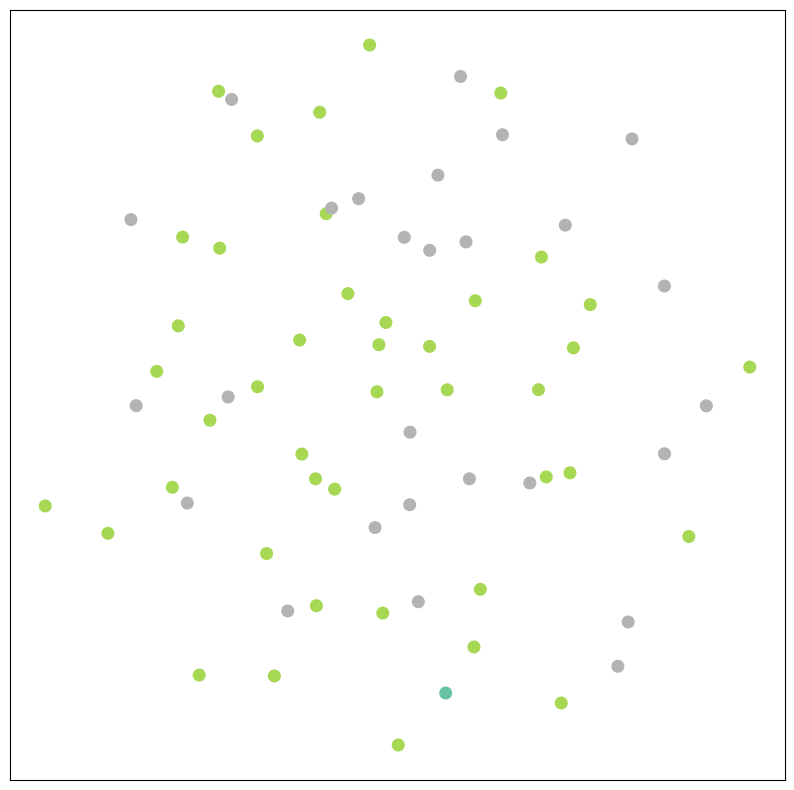

In [60]:
color = labels[data.test_mask]
visualize(data.x[data.test_mask], color)

## Craft features from node2vec

In [69]:
import pickle
if not Path("../data/n2v_embs.pcl").exists():
    # Prepare the graph
    G = nx.from_edgelist(data.edge_index.cpu().numpy().T)

    # Apply Node2Vec
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model_nv = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Extract node embeddings
    node_embeddings = {node: model_nv.wv[node] for node in G.nodes()}

    n2v_embs = [node_embeddings[idx] for idx in range(len(data.y))]
    with open("../data/n2v_embs.pcl", "wb") as f:
        pickle.dump(np.vstack(n2v_embs), f)
    n2v_embs = np.vstack(n2v_embs)
else:
    with open("../data/n2v_embs.pcl", "rb") as f:
        n2v_embs = pickle.load(f)

Computing transition probabilities:   0%|          | 0/900 [00:00<?, ?it/s]

C:\Users\ksenia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### GCN model

In [ ]:
data

In [70]:
data.x=torch.tensor(np.vstack(n2v_embs), dtype=torch.float32)
data.to(device)

# Initialize the model, optimizer_gcn_nv, and loss function
model_gcn_nv = GCN(in_channels=data.x.shape[1], hidden_channels=64, out_channels=2).to(device)
optimizer_gcn_nv = torch.optim.Adam(model_gcn_nv.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model_gcn_nv.train()
    optimizer_gcn_nv.zero_grad()
    out = model_gcn_nv(data)
    print(out.shape)
    print(data.train_mask.shape)
    # loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    # loss.backward()
    # optimizer_gcn_nv.step()
    # return loss.item()

def test():
    model_gcn_nv.eval()
    with torch.no_grad():
        logits = model_gcn_nv(data)
        test_mask = data.test_mask
        pred = logits[test_mask].max(1)[1]
        acc = pred.eq(data.y[test_mask]).sum().item() / test_mask.sum().item()
    return acc

# Train the model_gcn_nv
for epoch in range(100):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

print('Final Test Accuracy:', acc)

RuntimeError: index 866 is out of bounds for dimension 0 with size 353